<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(400,)
Epoch 1/150
2/2 [==============================] - 6s 3s/step - loss: 249.6505 - mae: 262.1309
Epoch 2/150
2/2 [==============================] - 1s 557ms/step - loss: 195.2826 - mae: 191.2462
Epoch 3/150
2/2 [==============================] - 1s 582ms/step - loss: 123.2668 - mae: 121.2256
Epoch 4/150
2/2 [==============================] - 1s 653ms/step - loss: 87.5694 - mae: 87.7489
Epoch 5/150
2/2 [==============================] - 1s 558ms/step - loss: 91.0697 - mae: 92.3782
Epoch 6/150
2/2 [==============================] - 1s 596ms/step - loss: 103.8188 - mae: 104.3667
Epoch 7/150
2/2 [==============================] - 1s 586ms/step - loss: 98.1709 - mae: 97.8780
Epoch 8/150
2/2 [==============================] - 1s 574ms/step - loss: 84.6941 - mae: 84.8503
Epoch 9/150
2/2 [==============================] - 1s 604ms/step - loss: 84.1550 - mae: 84.8774
Epoch 10/150
2/2 [============

2/2 [==============================] - 1s 610ms/step - loss: 83.4002 - mae: 84.0896
Epoch 85/150
2/2 [==============================] - 1s 684ms/step - loss: 76.9733 - mae: 77.6022
Epoch 86/150
2/2 [==============================] - 1s 654ms/step - loss: 81.0962 - mae: 80.9603
Epoch 87/150
2/2 [==============================] - 1s 637ms/step - loss: 77.6682 - mae: 78.7195
Epoch 88/150
2/2 [==============================] - 1s 646ms/step - loss: 76.9065 - mae: 77.6356
Epoch 89/150
2/2 [==============================] - 1s 626ms/step - loss: 82.8246 - mae: 82.3850
Epoch 90/150
2/2 [==============================] - 1s 593ms/step - loss: 84.1146 - mae: 84.0102
Epoch 91/150
2/2 [==============================] - 1s 709ms/step - loss: 80.0870 - mae: 80.7152
Epoch 92/150
2/2 [==============================] - 1s 677ms/step - loss: 77.3499 - mae: 78.0891
Epoch 93/150
2/2 [==============================] - 1s 615ms/step - loss: 77.6394 - mae: 78.1626
Epoch 94/150
2/2 [=========================

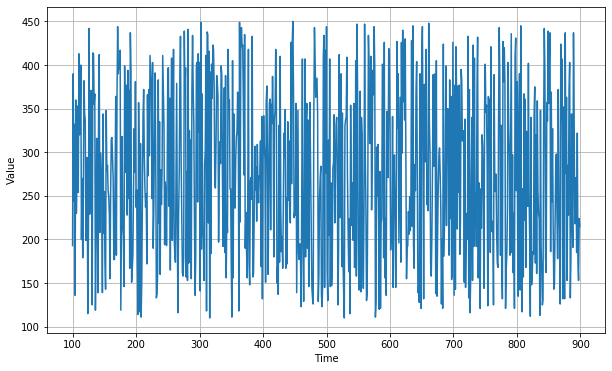

In [51]:
import csv
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

time_step = []
temps = []
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
q = pd.read_csv("Diuresis_TR.csv")
step=0
for i in range(1,8):
    for j in range(10714):
        temps.append(float(q.iloc[j, i]))
        time_step.append(step)
        step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time[100:900], series[100:900])

split_time = 200
time_train = time[100:500]
x_train = series[100:500]
time_valid = time[500:900]
x_valid = series[500:900]

shuffle_buffer_size = 1000

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast


tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 80
batch_size = 250
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 50))
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=150, callbacks=[lr_schedule])

[1e-08, 0.1, 30, 1000]

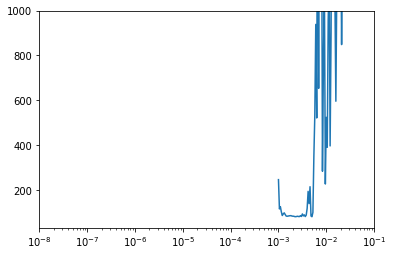

In [56]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-1, 30, 1000])

In [62]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=70, batch_size=250, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 50))
optimizer = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=50, callbacks=[lr_schedule])

Epoch 1/50
2/2 [==============================] - 4s 2s/step - loss: 265.9711 - mae: 276.3555
Epoch 2/50
2/2 [==============================] - 1s 250ms/step - loss: 198.0378 - mae: 192.6609
Epoch 3/50
2/2 [==============================] - 1s 258ms/step - loss: 117.1118 - mae: 114.9381
Epoch 4/50
2/2 [==============================] - 1s 279ms/step - loss: 87.7567 - mae: 88.5796
Epoch 5/50
2/2 [==============================] - 1s 285ms/step - loss: 97.0311 - mae: 98.0096
Epoch 6/50
2/2 [==============================] - 1s 263ms/step - loss: 98.3099 - mae: 97.6344
Epoch 7/50
2/2 [==============================] - 1s 267ms/step - loss: 82.9034 - mae: 83.7656
Epoch 8/50
2/2 [==============================] - 1s 276ms/step - loss: 88.3380 - mae: 88.4909
Epoch 9/50
2/2 [==============================] - 1s 265ms/step - loss: 82.9020 - mae: 83.1351
Epoch 10/50
2/2 [==============================] - 1s 279ms/step - loss: 82.3962 - mae: 82.8817
Epoch 11/50
2/2 [=============================

In [63]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)

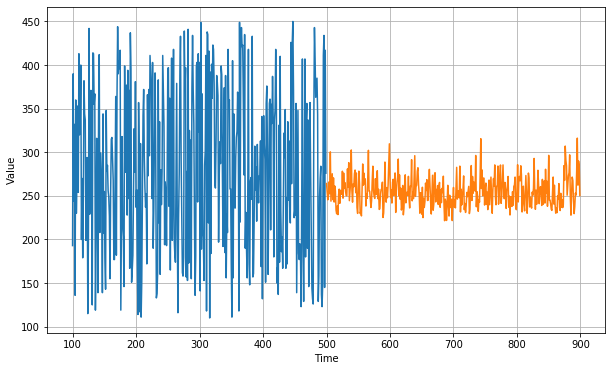

In [66]:
#rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
#rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plot_series(time_valid, rnn_forecast[500:900])

In [61]:
#print(tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())
print(rnn_forecast)
#Creation of csv file to store predicted data of infected probability.

rnn_forecast.to_csv(r'Task2.csv', index = False)

[-42900.562 -42900.562 -42900.562 ... -42900.562 -42900.562 -42900.562]


AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

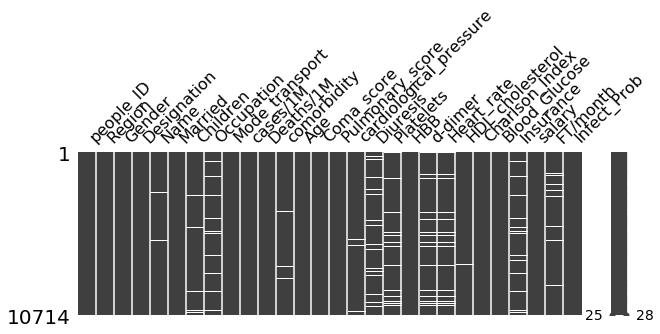

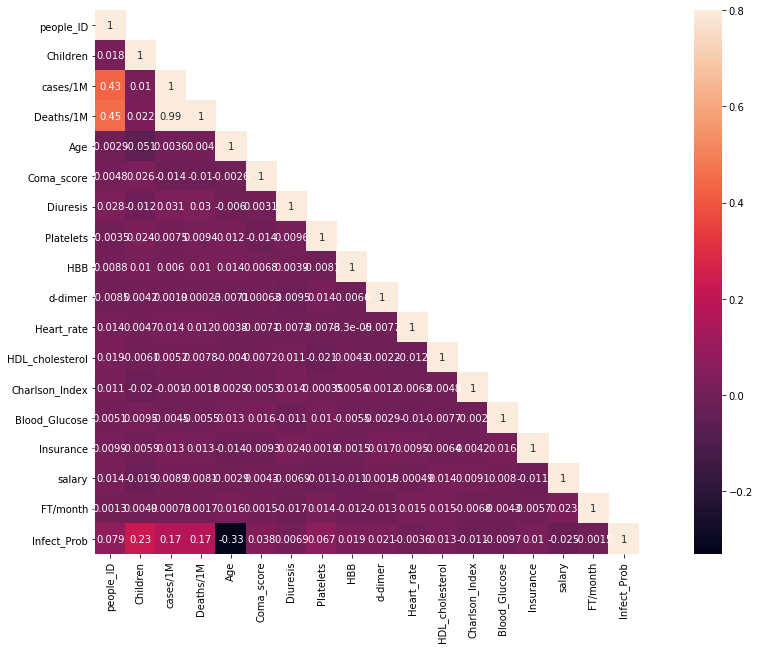

In [6]:
msno.matrix(df, figsize = (10,3))


corr_mat = df.corr()
mask = np.array(corr_mat)
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corr_mat, mask = mask, vmax = 0.8, square = True, annot = True)